# What if we increase the sim time?

In [1]:
import torch as t
from scipy import ndimage
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
device = t.device('cuda' if t.cuda.is_available() else 'cpu')

In [3]:
MOORE_OFFSETS = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (0, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)], device=device)
def get_moore_nbh(batch:t.Tensor):
    cell_pixel_coords = (batch == 1).nonzero()
    nbh_coords = (cell_pixel_coords[:, 1:].unsqueeze(1)+MOORE_OFFSETS.type(t.float).unsqueeze(0))
    idx_pad = cell_pixel_coords[:, 0].repeat(9,1).T.reshape(cell_pixel_coords[:, 0].shape[0], 9, 1)
    return t.concatenate((idx_pad, nbh_coords), dim=-1)

In [4]:
STEP_SIZES = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)], device=device)

def MCS(batch, target_vol, temperature):
    batch_size, batch_height, batch_width = batch.shape
    frontiers = get_moore_nbh(batch)
    
    src_coords = []
    for batch_idx in range(batch_size):
        frontier = frontiers[frontiers[:, :, 0] == batch_idx, :].unique(dim=0)
        src_coords.append(random.choice(frontier).type(t.long))
    batch_src_coords = t.vstack(src_coords)
    step_sizes = t.vstack(random.choices(STEP_SIZES, k=batch_src_coords.shape[0]))
    tgt_coords = t.hstack((batch_src_coords[:, 0].unsqueeze(0).T, batch_src_coords[:, 1:] + step_sizes))
    tgt_coords[:, 1:][tgt_coords[:, 1:] == -1] = 1
    tgt_coords[:, 1:][tgt_coords[:, 1:] == batch_height] = batch_height -2
    tgt_i = tgt_coords[:, 0]
    tgt_j = tgt_coords[:, 1]
    tgt_k = tgt_coords[:, 2]
    src_i = batch_src_coords[:, 0]
    src_j = batch_src_coords[:, 1]
    src_k = batch_src_coords[:, 2]
    
    
    current_volumes = t.sum(batch, dim=(-1, -2))
    vol_changes = (-1 * batch[tgt_i, tgt_j, tgt_k]) + batch[src_i, src_j, src_k]
    adjusted_vols = current_volumes + vol_changes
    
    unequal_mask = batch[tgt_i, tgt_j, tgt_k] != batch[src_i, src_j, src_k]
    sml_eq_two_mask = adjusted_vols <= 2
    greater_zero_mask = adjusted_vols > 0
    update_mask = t.logical_and(greater_zero_mask, t.logical_and(unequal_mask, sml_eq_two_mask))
    
    #print(f"delta h {-((target_vol - adjusted_vols[update_mask]) ** 2)}")
    update_probabilities = t.exp(-((target_vol - adjusted_vols[update_mask]) ** 2) / temperature)
    #print(f"prob: {update_probabilities}")
    logits = t.cat((update_probabilities.unsqueeze(0), (1-update_probabilities).unsqueeze(0))).T
    #print(f"logits: {logits}")
    one_hot = t.nn.functional.gumbel_softmax(t.log(logits), hard=True)
    #print(one_hot)
    upd_vals = one_hot[:,0] * vol_changes[update_mask]
    
    upd_i = tgt_i[update_mask]
    upd_j = tgt_j[update_mask]
    upd_k = tgt_k[update_mask]
    
    #print(upd_i, upd_j, upd_k)
    
    batch[upd_i, upd_j, upd_k] += upd_vals.squeeze()
    
    return batch
    

In [5]:
def step(batch:t.Tensor, dist_matrix:t.Tensor, temperature:t.Tensor, target_vol:float, eta:float):
    temperature.requires_grad_()
    for i in tqdm(range(500)):
        #print(f"-------- MCS {i} --------------")
        batch = MCS(batch, target_vol, temperature)
        if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
            print("ISSUE DETECTED, STOP SIM")
            return None, None
    # calc the distance after 100 steps    
    distances = t.sum(batch * dist_matrix, dim=(-1,-2)) / t.sum(batch, dim=(-1,-2))
    mean_distance = t.mean(distances)
    print(f"temperature: {temperature}, mean distance: {mean_distance}")
    loss = (mean_distance - 5)**2 
    print(f"loss: {loss}")
    grad = t.autograd.grad(loss, temperature)[0]
    print(f"gradient: {grad}")
    return t.clamp(temperature - (eta * grad), min=1e-5, max=40.), grad, loss, mean_distance

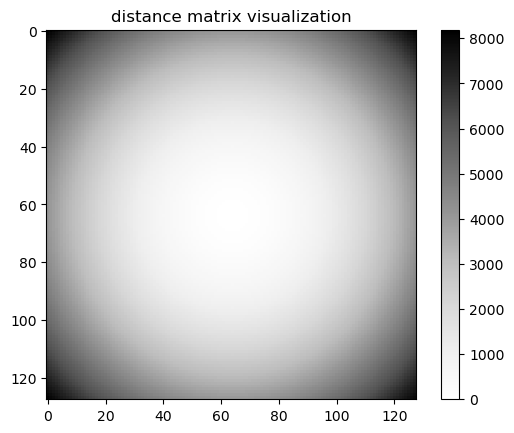

In [10]:
init_state = t.zeros(1000,128,128, device=device)
init_state[:,64,64] += 1
ref_state = init_state.detach().clone()

dist_matrix:np.ndarray = ndimage.distance_transform_edt(1-init_state[0].cpu(), return_indices=False)
dist_matrix = dist_matrix**2
dist_matrix_t = t.from_numpy(dist_matrix).to(device)
fig = plt.imshow(dist_matrix, cmap="Greys", interpolation="nearest", vmin=0, vmax=np.max(dist_matrix))
plt.colorbar(fig)
plt.title("distance matrix visualization")
plt.show()

In [11]:
temps = t.linspace(1, 35, 35)
target_vol = 0.

losses = []
grads = []
mean_distances = []
std_distances = []
for temp in temps:
    temp.requires_grad_()
    batch = init_state.detach().clone()
    new_temp, grad, loss, mean_distance = step(batch, dist_matrix_t, temp, target_vol, eta=1)
    losses.append(loss.detach().cpu().numpy())
    grads.append(grad.detach().cpu().numpy())
    mean_distances.append(mean_distance.detach().cpu().numpy())

100%|██████████| 500/500 [05:39<00:00,  1.47it/s]


temperature: 1.0, mean distance: 0.7175
loss: 18.33980625
gradient: 4.642467498779297


100%|██████████| 500/500 [05:41<00:00,  1.46it/s]


temperature: 2.0, mean distance: 4.8165000000000004
loss: 0.033672249999999834
gradient: 1.0441597700119019


100%|██████████| 500/500 [05:25<00:00,  1.54it/s]


temperature: 3.0, mean distance: 8.012
loss: 9.072144000000003
gradient: -14.715740203857422


100%|██████████| 500/500 [05:04<00:00,  1.64it/s]


temperature: 4.0, mean distance: 11.175
loss: 38.13062500000001
gradient: -30.21312141418457


100%|██████████| 500/500 [05:11<00:00,  1.60it/s]


temperature: 5.0, mean distance: 12.9525
loss: 63.24225625000001
gradient: -30.86785125732422


100%|██████████| 500/500 [05:57<00:00,  1.40it/s]


temperature: 6.0, mean distance: 13.058
loss: 64.931364
gradient: -27.439329147338867


100%|██████████| 500/500 [04:59<00:00,  1.67it/s]


temperature: 7.0, mean distance: 16.105
loss: 123.321025
gradient: -30.262666702270508


100%|██████████| 500/500 [05:02<00:00,  1.65it/s]


temperature: 8.0, mean distance: 15.966000000000001
loss: 120.25315600000002
gradient: -23.885990142822266


100%|██████████| 500/500 [04:36<00:00,  1.81it/s]


temperature: 9.0, mean distance: 18.165
loss: 173.31722499999998
gradient: -16.97954559326172


100%|██████████| 500/500 [05:12<00:00,  1.60it/s]


temperature: 10.0, mean distance: 17.3435
loss: 152.36199224999996
gradient: -11.064125061035156


100%|██████████| 500/500 [04:35<00:00,  1.82it/s]


temperature: 11.0, mean distance: 18.5165
loss: 182.69577225
gradient: -6.63433313369751


100%|██████████| 500/500 [05:32<00:00,  1.50it/s]


temperature: 12.0, mean distance: 17.7605
loss: 162.83036025
gradient: 1.193913221359253


100%|██████████| 500/500 [05:46<00:00,  1.44it/s]


temperature: 13.0, mean distance: 17.629
loss: 159.49164100000004
gradient: 3.2523932456970215


100%|██████████| 500/500 [05:40<00:00,  1.47it/s]


temperature: 14.0, mean distance: 18.0915
loss: 171.38737225
gradient: 2.251542806625366


100%|██████████| 500/500 [05:49<00:00,  1.43it/s]


temperature: 15.0, mean distance: 19.415
loss: 207.79222499999997
gradient: 0.48599183559417725


100%|██████████| 500/500 [05:49<00:00,  1.43it/s]


temperature: 16.0, mean distance: 19.8455
loss: 220.38887025000002
gradient: 3.9046030044555664


100%|██████████| 500/500 [05:44<00:00,  1.45it/s]


temperature: 17.0, mean distance: 20.341
loss: 235.34628100000003
gradient: 12.260418891906738


100%|██████████| 500/500 [05:44<00:00,  1.45it/s]


temperature: 18.0, mean distance: 20.7905
loss: 249.33989025000005
gradient: 10.868908882141113


100%|██████████| 500/500 [05:36<00:00,  1.49it/s]


temperature: 19.0, mean distance: 20.4585
loss: 238.96522225
gradient: 5.045452117919922


100%|██████████| 500/500 [05:11<00:00,  1.60it/s]


temperature: 20.0, mean distance: 20.7135
loss: 246.91408225
gradient: 6.6072235107421875


100%|██████████| 500/500 [05:16<00:00,  1.58it/s]


temperature: 21.0, mean distance: 20.223
loss: 231.73972899999998
gradient: 6.666614055633545


100%|██████████| 500/500 [04:56<00:00,  1.68it/s]


temperature: 22.0, mean distance: 21.302
loss: 265.755204
gradient: 4.839819431304932


100%|██████████| 500/500 [04:57<00:00,  1.68it/s]


temperature: 23.0, mean distance: 19.7295
loss: 216.95817025000005
gradient: 5.737711429595947


100%|██████████| 500/500 [05:04<00:00,  1.64it/s]


temperature: 24.0, mean distance: 21.511
loss: 272.613121
gradient: 7.2058939933776855


100%|██████████| 500/500 [05:48<00:00,  1.44it/s]


temperature: 25.0, mean distance: 19.839000000000002
loss: 220.19592100000006
gradient: 5.432277679443359


100%|██████████| 500/500 [05:07<00:00,  1.62it/s]


temperature: 26.0, mean distance: 21.578
loss: 274.830084
gradient: 7.406979560852051


100%|██████████| 500/500 [05:09<00:00,  1.62it/s]


temperature: 27.0, mean distance: 20.871
loss: 251.88864099999995
gradient: 5.034209728240967


100%|██████████| 500/500 [04:58<00:00,  1.68it/s]


temperature: 28.0, mean distance: 20.6585
loss: 245.18862225
gradient: 4.249477863311768


100%|██████████| 500/500 [05:17<00:00,  1.58it/s]


temperature: 29.0, mean distance: 21.3765
loss: 268.18975225
gradient: 8.220514297485352


100%|██████████| 500/500 [05:09<00:00,  1.62it/s]


temperature: 30.0, mean distance: 20.873
loss: 251.95212900000004
gradient: 3.9358325004577637


100%|██████████| 500/500 [05:19<00:00,  1.57it/s]


temperature: 31.0, mean distance: 19.275000000000002
loss: 203.77562500000005
gradient: 4.596775531768799


100%|██████████| 500/500 [05:02<00:00,  1.65it/s]


temperature: 32.0, mean distance: 21.3975
loss: 268.87800625000006
gradient: 4.013181209564209


100%|██████████| 500/500 [04:16<00:00,  1.95it/s]


temperature: 33.0, mean distance: 22.061
loss: 291.077721
gradient: 4.735557556152344


100%|██████████| 500/500 [04:44<00:00,  1.76it/s]


temperature: 34.0, mean distance: 22.1825
loss: 295.23830625000005
gradient: 3.782588005065918


100%|██████████| 500/500 [03:48<00:00,  2.19it/s]


temperature: 35.0, mean distance: 21.855
loss: 284.091025
gradient: 3.035618543624878


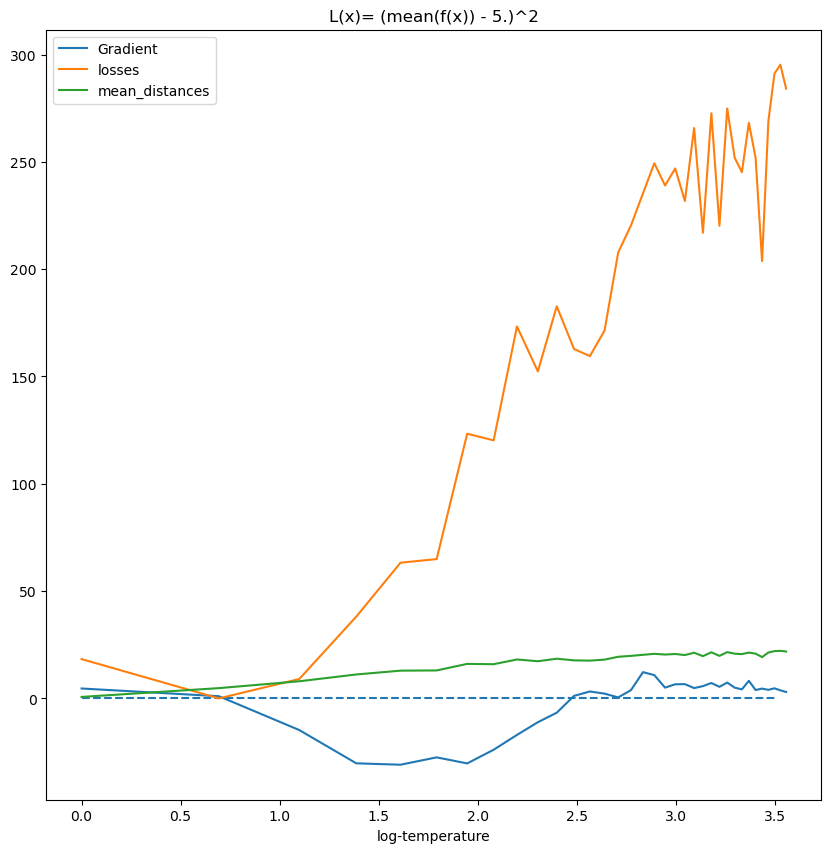

In [13]:
x_vals = t.log(temps).cpu().numpy()

plt.figure(figsize=(10,10))
plt.plot(x_vals,grads, label="Gradient")
plt.hlines([0.], xmin=0, xmax=3.5, linestyles="dashed")
plt.plot(x_vals, np.stack(losses, axis=0), label="losses")
plt.plot(x_vals, np.stack(mean_distances, axis=0), label="mean_distances")
plt.title("L(x)= (mean(f(x)) - 5.)^2")
plt.xlabel("log-temperature")
plt.legend()
